In [163]:
import pandas as pd
import numpy as np
import sidetable
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



import warnings
warnings.filterwarnings('ignore')

<div style="background-color: aliceblue; border: 1.5px solid blue; border-left: 5px solid blue; padding: 0.8em; font-size: 20px">
<strong>1. DATA INFORMATION AND DATA LOADING</strong>
</div>

Los datos utilizados para este proyecto parten de archivos xml que pueden encontrarse en este [enlace](https://github.com/abachaa/LiveQA_MedicalTask_TREC2017/tree/master).

In [124]:
df = pd.read_json('../data/json/train_cleaned.json')

In [125]:
df = pd.json_normalize(df['nlm_question'])

In [126]:
df.head()

,subject,message,qid,f_ref,sub_questions.sub_question
0,Lyme Disease,12 years ago I was bitten by tick while deer h...,1.0,None,"[{'annotations': {'focus': ['Lyme Disease'], '..."
1,Raynauds Syndrome,My sons middle toe turned white after being in...,2.0,None,[{'annotations': {'focus': ['Raynauds Syndrome...
2,burn to my wrist,Hello I burnt my wrist 2 days ago and after la...,5.0,None,"[{'annotations': {'focus': ['burn'], 'type_val..."
3,treatment of parkinson,I AM HAVING PARKINSON FOR LAST 8 YEARS. SO FAR...,6.0,None,"[{'annotations': {'focus': ['Parkinson'], 'typ..."
4,Periventricular Heterotopia. Scoliosis - pos...,Question in laymen terms: Has any genetic or o...,8.0,None,[{'annotations': {'focus': ['Periventricular H...


In [127]:
df.shape

(446, 5)

In [128]:
print(df['sub_questions.sub_question'][0])

[{'annotations': {'focus': ['Lyme Disease'], 'type_value': 'Information'}, 'answers': {'answer': [{'value': 'Lyme disease tests are used to determine if a person with characteristic symptoms has been infected by Borrelia burgdorferi. If the doctor suspects a recent infection, then she may order both an IgM and IgG antibody blood test. If they are negative but symptoms persist, then the tests may be ordered again a few weeks later…Lyme disease can sometimes be challenging to diagnose', 'answerid': None, 'pairid': None}]}, 'subqid': None}]


In [129]:
expanded_sub_questions = pd.json_normalize(df['sub_questions.sub_question'].explode())

In [130]:
# We join expanded df with original df
df = df.drop(columns=['sub_questions.sub_question']).join(expanded_sub_questions)

In [131]:
df.head()

,subject,message,qid,f_ref,subqid,annotations.focus,annotations.type_value,answers.answer
0,Lyme Disease,12 years ago I was bitten by tick while deer h...,1.0,None,None,[Lyme Disease],Information,[{'value': 'Lyme disease tests are used to det...
1,Raynauds Syndrome,My sons middle toe turned white after being in...,2.0,None,None,[Raynauds Syndrome],Symptom,[{'value': 'Only one finger or toe or parts of...
2,burn to my wrist,Hello I burnt my wrist 2 days ago and after la...,5.0,None,None,[burn],Treatment,"[{'value': 'Before giving first aid, it is imp..."
3,treatment of parkinson,I AM HAVING PARKINSON FOR LAST 8 YEARS. SO FAR...,6.0,None,None,[Parkinson],Treatment,[{'value': 'you should know that people who ha...
4,Periventricular Heterotopia. Scoliosis - pos...,Question in laymen terms: Has any genetic or o...,8.0,None,None,[Periventricular Heterotopia/ Scoliosis],information,[{'value': 'Isolated lissencephaly sequence (I...


In [143]:
df.shape

(446, 7)

In [144]:
df.dtypes

subject                   object
message                   object
qid                       object
subqid                    object
annotations.focus         object
annotations.type_value    object
value                     object
dtype: object

In [132]:
df.stb.missing()

,missing,total,percent
f_ref,246,446,55.156951
subqid,246,446,55.156951
subject,0,446,0.000000
message,0,446,0.000000
qid,0,446,0.000000
annotations.focus,0,446,0.000000
annotations.type_value,0,446,0.000000
answers.answer,0,446,0.000000


In [150]:
df['annotations.type_value'].unique()

array(['Information', 'Symptom', 'Treatment', 'information',
       'Complication', 'Indication', 'Diagnosis', 'Organization',
       'Susceptibility', 'Prognosis', 'Cause', 'Diagnose_me',
       'Association', 'susceptibility', 'treatment', 'contraindication',
       'cause', 'symptom', 'genetic changes', 'inheritance', 'resources',
       'prevention', 'diagnosis', 'prognosis', 'complication', 'tapering',
       'side effects', 'dosage', 'association', 'indication'],
      dtype=object)

In [152]:
# vemos que algunos valores se repiten excepto por la mayúscula, por lo que cambiamos a minúscula la columna.
df['annotations.type_value'] = df['annotations.type_value'].apply(lambda x: x.lower())

In [153]:
df['annotations.type_value'].unique()

array(['information', 'symptom', 'treatment', 'complication',
       'indication', 'diagnosis', 'organization', 'susceptibility',
       'prognosis', 'cause', 'diagnose_me', 'association',
       'contraindication', 'genetic changes', 'inheritance', 'resources',
       'prevention', 'tapering', 'side effects', 'dosage'], dtype=object)

In [154]:
len(df['annotations.type_value'].unique())

20

In [180]:
df[df['annotations.type_value'] == 'diagnose_me']

,subject,message,qid,subqid,annotations.focus,annotations.type_value,value
38,Need help!,I have a knot about the size of a BB in my rig...,55.0,None,[a knot about the size of a BB in my right for...,diagnose_me,It is arm lump? An arm lump is a protuberance...


In [181]:
df['annotations.type_value'] = df['annotations.type_value'].apply(lambda x: x.replace('diagnose_me', 'diagnosis'))

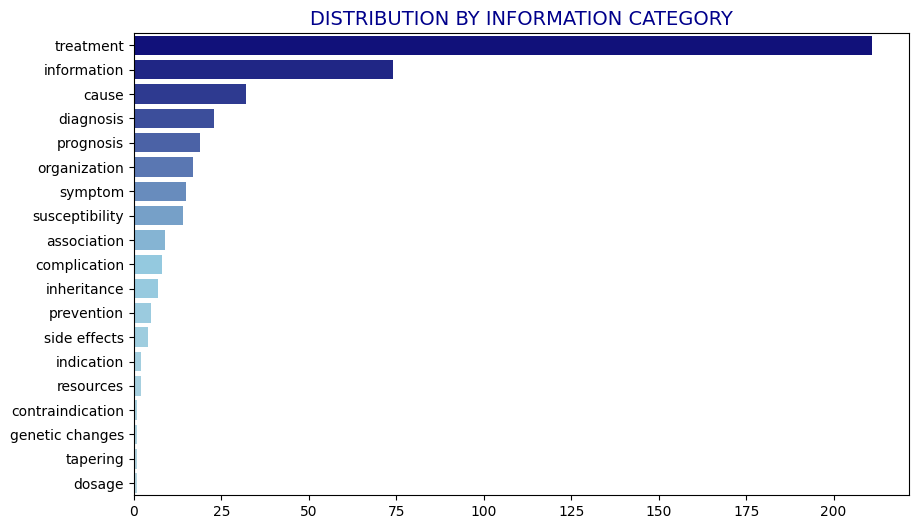

In [187]:
my_countplot_palette = LinearSegmentedColormap.from_list('Gradient', ['darkblue', 'skyblue', 'lightblue'])
num_bars = (len(df['annotations.type_value'].unique()))

plt.figure(figsize=(10, 6))
sns.countplot(y='annotations.type_value',
            data=df, palette= my_countplot_palette(np.linspace(0, 1, num_bars)),
            order=df['annotations.type_value'].value_counts().index)

plt.title('DISTRIBUTION BY INFORMATION CATEGORY', color='darkblue', fontsize=14)
plt.xlabel('')
plt.ylabel('')

plt.show()

In [134]:
print(df['answers.answer'][0])

[{'value': 'Lyme disease tests are used to determine if a person with characteristic symptoms has been infected by Borrelia burgdorferi. If the doctor suspects a recent infection, then she may order both an IgM and IgG antibody blood test. If they are negative but symptoms persist, then the tests may be ordered again a few weeks later…Lyme disease can sometimes be challenging to diagnose', 'answerid': None, 'pairid': None}]


In [135]:
expanded_answers = pd.json_normalize(df['answers.answer'].explode())

In [136]:
df = df.drop(columns=['answers.answer']).join(expanded_answers)

In [137]:
df.head()

,subject,message,qid,f_ref,subqid,annotations.focus,annotations.type_value,value,answerid,pairid
0,Lyme Disease,12 years ago I was bitten by tick while deer h...,1.0,None,None,[Lyme Disease],Information,Lyme disease tests are used to determine if a ...,None,NaN
1,Raynauds Syndrome,My sons middle toe turned white after being in...,2.0,None,None,[Raynauds Syndrome],Symptom,Only one finger or toe or parts of one or more...,None,NaN
2,burn to my wrist,Hello I burnt my wrist 2 days ago and after la...,5.0,None,None,[burn],Treatment,"Before giving first aid, it is important to de...",None,NaN
3,treatment of parkinson,I AM HAVING PARKINSON FOR LAST 8 YEARS. SO FAR...,6.0,None,None,[Parkinson],Treatment,you should know that people who have Parkinson...,None,NaN
4,Periventricular Heterotopia. Scoliosis - pos...,Question in laymen terms: Has any genetic or o...,8.0,None,None,[Periventricular Heterotopia/ Scoliosis],information,Isolated lissencephaly sequence (ILS) is a con...,None,NaN


In [138]:
df['f_ref'].unique()[:30]

array([None, '11373', '1-136434885', '1-123453375', '1-118260435',
       '1-132032443', '17730', '1-123897705', '1-133748113',
       '1-134322567', '1-135752923', '19832', '1-136400295',
       '1-131374625', '1-133026625', '1-135900462', '13550',
       '1-136744885', '1-132036525', '1-120034865', '13506',
       '1-136858845', '5288', '1-136022315', '1-135934082', 'NF_61',
       '14262', '1-136961537', '1-134470695', '1-132036455'], dtype=object)

In [139]:
df['answerid'].unique()[:30]

array([None, 'Q1-S1-A1', 'Q1-S1-A2', 'Q2-S1-A1', 'Q2-S1-A2', 'Q3-S1-A1',
       'Q4-S1-A1', 'Q5-S1-A1', 'Q6-S1-A1', 'Q6-S1-A2', 'Q6-S1-A3',
       'Q6-S2-A1', 'Q6-S2-A2', 'Q7-S1-A1', 'Q8-S1-A1', 'Q9-S1-A1',
       'Q10-S1-A1', 'Q10-S1-A2', 'Q11-S1-A1', 'Q11-S2-A1', 'Q12-S1-A1',
       'Q13-S1-A1', 'Q14-S1-A1', 'Q15-S1-A1', 'Q15-S1-A2', 'Q15-S1-A3',
       'Q16-S1-A1', 'Q17-S1-A1', 'Q17-S2-A1', 'Q18-S1-A1'], dtype=object)

In [140]:
df['pairid'].unique()[:30]

array([nan,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 23., 25., 26., 27., 30.,
       36., 37., 38., 39.])

In [141]:
# These columns does not contribute to our model, so we delete them.
df.drop(['f_ref', 'answerid', 'pairid'], axis=1, inplace=True)

In [142]:
df['annotations.focus'].apply(lambda x: len(x) > 1).sum()

np.int64(2)

In [133]:
df[df['subject'] == 'sir my testicular is small in size another is normal what is medical suggestion.thanks']

,subject,message,qid,f_ref,subqid,annotations.focus,annotations.type_value,answers.answer
58,sir my testicular is small in size another is ...,,78.0,None,None,[testicular is small in size],Treatment,[{'value': 'Treatment of male hypogonadism/and...
